## Mixture-VAE with GAS-SN: Generate Synthetic Data

In [1]:
import numpy as np
import pandas as pd 

from data_code.synthetic_data import generate_hmm_data

# Example usage
T = 100008 
D = 1
num_states = 2
startprob = np.array([1/num_states for i in range(num_states)])  # initial state probabilities

######################################################################################################################
transition_probs = np.array([[0.96, 0.04],
                             [0.04, 0.96]])

# Define t-distribution parameters
# (df, loc, scale)

df = 2.5
loc = 0.001  # 0.001-0.003
sd = 0.003 

# shape is covariance matrix, for t-distribution it is a diagonal matrix with sd^2 on the diagonal
# For multivariate t-distribution, we can use np.eye(D) * sd**2 for a diagonal covariance matrix
# For multivariate normal distribution, we can use np.eye(D) * sd**2 as well

t_params = [
    {'df': df, 'loc': np.full(D, -loc), 'shape': np.eye(D) * sd**2},
    {'df': df, 'loc': np.full(D, loc),  'shape': np.eye(D) * sd**2},
]


In [2]:

alpha = 1.0  # alpha=1 is student's t distribution
k = 2.5  # k is the degrees of freedom
beta = 0.0  # add skewness as you wish, but it adds a lot of complexity


assert D == 1, "This example is designed for D=1, the univariate GAS_SN class"

gassn_params = [
    {'alpha': alpha, 'k': k, 'beta': beta, 'loc': -loc, 'scale': sd, 'shape': np.eye(D) * sd**2},
    {'alpha': alpha, 'k': k, 'beta': beta, 'loc':  loc, 'scale': sd, 'shape': np.eye(D) * sd**2},
]



In [16]:
use_gassn = False

if use_gassn:
    S, X = generate_hmm_data(T=T, 
                         D=D, 
                         num_states=num_states, 
                         startprob=startprob,
                         transition_probs=transition_probs,
                         emission_dist='gassn',
                         hmm_params=gassn_params,
                         clip_factor=10.0,
                         chunk_size=10000,  # gas-sn is slow for small chunk size
                         )
else:
    S, X = generate_hmm_data(T=T, 
                            D=D, 
                            num_states=num_states, 
                            startprob=startprob,
                            transition_probs=transition_probs,
                            emission_dist='t',
                            hmm_params=t_params,
                            clip_factor=10.0,
                            chunk_size=1000,  # came with 1000, try 10000 to see Jump catching up
                            )




Rejection sampling for state 0: use std, lower=[-0.031], upper=[0.029]
2025-08-09 15:36:01.632285: Generating batch 1 of size 1000 for rejection sampling, len: 0, goal: 49428...
2025-08-09 15:36:01.634198: Generating batch 2 of size 1000 for rejection sampling, len: 996, goal: 49428...
2025-08-09 15:36:01.635656: Generating batch 3 of size 1000 for rejection sampling, len: 1992, goal: 49428...
2025-08-09 15:36:01.637105: Generating batch 4 of size 1000 for rejection sampling, len: 2991, goal: 49428...
2025-08-09 15:36:01.638599: Generating batch 5 of size 1000 for rejection sampling, len: 3985, goal: 49428...
2025-08-09 15:36:01.639951: Generating batch 6 of size 1000 for rejection sampling, len: 4977, goal: 49428...
2025-08-09 15:36:01.641385: Generating batch 7 of size 1000 for rejection sampling, len: 5972, goal: 49428...
2025-08-09 15:36:01.642810: Generating batch 8 of size 1000 for rejection sampling, len: 6970, goal: 49428...
2025-08-09 15:36:01.644182: Generating batch 9 of siz

In [17]:
# Kurtosis is affected by the clipping, otherwise, t(2.5) should have much worse kurtosis if not infinite

from scipy.stats import kurtosis, skew

print(f"mean: {np.mean(X):.4f} and std: {np.std(X):.4f}")
print(f"Skewness: {skew(X)}")
print(f"Kurtosis: {kurtosis(X)}")  # clip_factor affects the kurtosis

[ S.shape, X.shape ]

mean: -0.0000 and std: 0.0051
Skewness: [-0.01458907]
Kurtosis: [4.73606086]


[(100008,), (100008, 1)]

In [18]:
for state in np.unique(S):
    X_state = X[S == state]
    print(f"Category {state}: len: {len(X_state)}, mean: {np.mean(X_state):.4f} and std: {np.std(X_state):.4f}")
    print(f"Skewness: {skew(X_state)}")
    print(f"Kurtosis: {kurtosis(X_state)}")  # clip_factor affects the kurtosis

Category 0: len: 49428, mean: -0.0010 and std: 0.0050
Skewness: [-0.0453435]
Kurtosis: [5.09582707]
Category 1: len: 50580, mean: 0.0010 and std: 0.0050
Skewness: [0.00867465]
Kurtosis: [5.10122413]


1D plotting


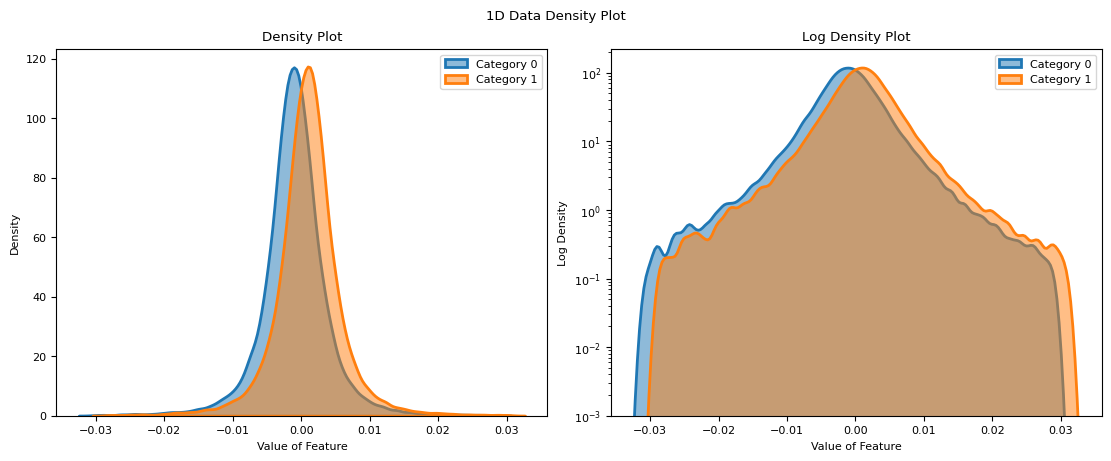

In [19]:
from utils.visualize import plot_clusters

plot_clusters(
    data=X,
    cluster_labels=S,
    title="1D Data Density Plot",
)

# Create Dataloader

In [20]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 500
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, 
    train_ratio=0.6, val_ratio=0.2, 
    batch_size=batch_size, standardize=True, feature_engineer=True
)

# Create Mixture-VAE Model and fit it

In [21]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 1.0
    hard = False
    transition = 'jump'
    lamda_m = 4.0
    lamda_i = 4.0
    lamda_t = 4.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [22]:
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=500)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy: {vae_bal_acc:.4f}")

Epoch [20/500], VAE Loss: 11289.2456
Epoch [40/500], VAE Loss: 10706.0479
Epoch [60/500], VAE Loss: 10425.8533
Epoch [80/500], VAE Loss: 10303.4384
Epoch [100/500], VAE Loss: 10219.6992
Epoch [120/500], VAE Loss: 10141.0375
Epoch [140/500], VAE Loss: 10111.9413
Epoch [160/500], VAE Loss: 10082.2206
Epoch [180/500], VAE Loss: 10058.1815
Epoch [200/500], VAE Loss: 10030.0898
Epoch [220/500], VAE Loss: 10010.2766
Epoch [240/500], VAE Loss: 10007.6767
Epoch [260/500], VAE Loss: 9985.0236
Epoch [280/500], VAE Loss: 9976.5762
Epoch [300/500], VAE Loss: 9985.2111
Epoch [320/500], VAE Loss: 9959.1846
Epoch [340/500], VAE Loss: 9945.3241
Epoch [360/500], VAE Loss: 9943.8815
Epoch [380/500], VAE Loss: 9939.6591
Epoch [400/500], VAE Loss: 9911.0654
Epoch [420/500], VAE Loss: 9910.3758
Epoch [440/500], VAE Loss: 9915.1753
Epoch [460/500], VAE Loss: 9905.6264
Epoch [480/500], VAE Loss: 9905.6603
Epoch [500/500], VAE Loss: 9878.7098
[VAE] Balanced Accuracy: 0.6639


# Visualization

In [23]:
# Get the embeddings
num = 8
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

## plot the clusters in the original space

Higher dimensional plotting: 15D


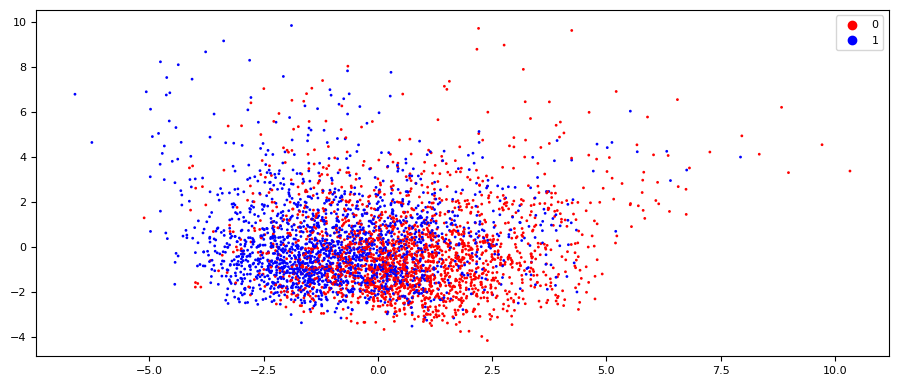

In [24]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

## plot the clusters in the latent space

Higher dimensional plotting: 16D


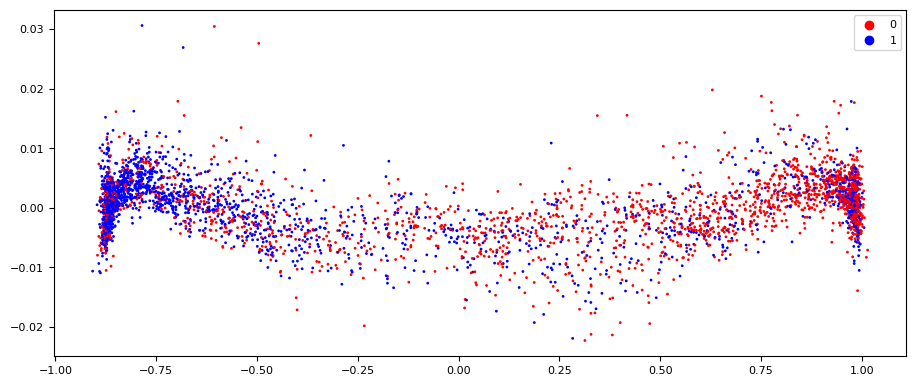

In [25]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

# Other Models

## Jump Model

chunk size seems to affect its BAC relative to VAE quite a bit.

Small chunk size makes Jump much worse (low 50's) than VAE (high 60's), while large chunk size makes Jump better (high 60's).

But GAS-SN seems much friendlier to Jump (high 60's, and a bit higher than VAE) !? I don't understand this.

In [ ]:
from model.jump_module import JumpModule

jump_penalty = 100.0
jump = JumpModule(num_states, jump_penalty=jump_penalty, max_iter=100)
jump.fit(train_loader)
true_s_test_jump, pred_s_test_jump = jump.inference(test_loader)

jump_bal_acc = balanced_accuracy(true_s_test_jump.ravel(), pred_s_test_jump.ravel(), n_classes = num_states)
print(f"[Jump] Balanced Accuracy: {jump_bal_acc:.4f}")

## KMeans++

In [ ]:
from model.kmeans_module import KMeansModule

kmeans = KMeansModule(n_clusters=num_states, n_init=10, max_iter=300)
kmeans.fit(train_loader)
true_s_test_kmeans, pred_s_test_kmeans = kmeans.inference(test_loader)

kmeans_bal_acc = balanced_accuracy(true_s_test_kmeans.ravel(), pred_s_test_kmeans.ravel(), n_classes = num_states)
print(f"[KMeans] Balanced Accuracy: {kmeans_bal_acc:.4f}")

[KMeans] Balanced Accuracy: 0.5029


## Gaussian-HMM

In [ ]:
from model.hmm_module import GaussianHMMModule

hmm_model = GaussianHMMModule(n_components=num_states, covariance_type='full', n_iter=100, random_state=42)
hmm_model.fit(train_loader)
true_s_test_hmm, pred_s_test_hmm = hmm_model.inference(test_loader)

# Evaluation
hmm_bal_acc = balanced_accuracy(true_s_test_hmm.ravel(), pred_s_test_hmm.ravel(), n_classes = num_states)
print(f"[HMM] Balanced Accuracy: {hmm_bal_acc:.4f}")

Model is not converging.  Current: 537459.8660368222 is not greater than 640861.6061609758. Delta is -103401.74012415356


[HMM] Balanced Accuracy: 0.5002
